In [78]:
#testing

import torch
import torch.nn as nn
import torch.nn.functional as F
from models.networks.basicCoders import BasicDecoderV3

class PeriodicConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(PeriodicConvTranspose2d, self).__init__()
        self.padding = padding
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        # Pad input tensor with periodic boundary conditions
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), mode='circular')
        # Apply convolution
        x = self.conv(x)
        return x

class sequentialMultiInput(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs

class DecoderCNNPBv4_HEMOD(BasicDecoderV3):
    def __init__(self, num_input_nodes, num_output_nodes, output_activation_fct=nn.Identity(), **kwargs):
        super(DecoderCNNPBv4_HEMOD, self).__init__(**kwargs)
        self._output_activation_fct = output_activation_fct
        self.num_input_nodes = num_input_nodes
        self.z = 45
        self.r = 9
        self.phi = 16
        self.hierarchal_outputs = num_output_nodes
        self.output_layers = int(self.hierarchal_outputs / 144)
        
        # self._node_sequence = [(2049, 800), (800, 700), (700, 600), (600, 550), (550, 500), (500, 6480)]
        self._layers =  nn.Sequential(
                   # nn.Unflatten(1, (self._node_sequence[0][0]-1, 1,1)),
                   nn.Unflatten(1, (self.num_input_nodes, 1,1)),

                   PeriodicConvTranspose2d(self.num_input_nodes, 1024, (3,5), 2, 0),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),
                   

                   PeriodicConvTranspose2d(1024, 512, (3,5), 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                                   )
        
        self._layers2 = nn.Sequential(
                   PeriodicConvTranspose2d(513, 128, (3,5), 1, 0),
                   nn.BatchNorm2d(128),
                   nn.PReLU(128, 0.02),

                   PeriodicConvTranspose2d(128, self.output_layers, (3,4), 1, 0),
                   # nn.BatchNorm2d(45),
                   nn.PReLU(self.output_layers, 1.0),
                                   )
        
        self._layers3 = nn.Sequential(
                   PeriodicConvTranspose2d(513, 128, (3,5), 1, 0),
                   nn.BatchNorm2d(128),
                   nn.PReLU(128, 0.02),

                   PeriodicConvTranspose2d(128, self.output_layers, (3,4), 1, 0),
                   # nn.BatchNorm2d(45),
                   nn.PReLU(self.output_layers, 0.02),
                                   )
        
    def forward(self, x, x0):
        print("t1: ", x.shape)
        x = self._layers(x)
        print("t2: ", x.shape)
        x0 = self.trans_energy(x0)
        xx0 = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item())), 1)
        x1 = self._layers2(xx0)
        x2 = self._layers3(xx0)
        # need channels * height * width = self.hierarchal_outputs = 1620
        return x1.reshape(x1.shape[0], self.hierarchal_outputs), x2.reshape(x1.shape[0], self.hierarchal_outputs)
    
    def trans_energy(self, x0, log_e_max=14.0, log_e_min=6.0, s_map = 15 * 1.2812657528661318):
        # s_map = max(scaled voxel energy u_i) * (incidence energy / slope of total energy in shower) of the dataset
        return ((torch.log(x0) - log_e_min)/(log_e_max - log_e_min)) * s_map

class DecoderCNNPB_HEv1(BasicDecoderV3):
    def __init__(self, encArch = 'Large', **kwargs):
        self.encArch = encArch
        super(DecoderCNNPB_HEv1, self).__init__(**kwargs)

    def _create_hierarchy_network(self, level: int = 0):
        self.latent_nodes = 2048
        self.layer_step = 11*144
        self.hierarchiel_lvls = 4

        inp_layers = [self.latent_nodes + i * self.layer_step for i in range(self.hierarchiel_lvls)] 
        out_layers = 4 * [self.layer_step]
        out_layers[3] += (6480 - 4 * self.layer_step)

        self.moduleLayers = nn.ModuleList([])
        for i in range(len(inp_layers)):
            self.moduleLayers.append(DecoderCNNPBv4_HEMOD(inp_layers[i], out_layers[i]))
            
        sequential = sequentialMultiInput(*self.moduleLayers)
        return sequential
    
    def forward(self, x, x0):
        self._create_hierarchy_network()
        self.sub_values = []
        x1, x2 = torch.tensor([]), torch.tensor([])
        for lvl in range(self.hierarchiel_lvls):
            cur_net = self.moduleLayers[lvl]
            hits, acts = cur_net(x, x0)
            beta = torch.tensor(self._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
            out.output_activations = self._energy_activation_fct(output_activations) * self._hit_smoothing_dist_mod(output_hits, beta, is_training)
            z = out.output_activations
            self.sub_values.append([hits, acts])
            if lvl == self.hierarchiel_lvls - 1:
                for vals in self.sub_values:
                    x1 = torch.cat((x1, vals[0]), dim=1)
                    x2 = torch.cat((x2, vals[1]), dim=1)
            else:
                x = torch.cat((x, z), dim=1)
        return x1, x2

In [80]:
# need to load config?
testDec = DecoderCNNPB_HEv1()
print(testDec.encArch)
x = torch.rand([1, 2048])
x0 = torch.rand([1, 1])
res = testDec.forward(x, x0)
print(len(res))
print(res[0].shape, res[1].shape)

Initializing NetworkV3
Large
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
t1:  torch.Size([1, 2048])
t2:  torch.Size([1, 512, 5, 9])


AttributeError: 'NoneType' object has no attribute 'model'

In [82]:
testDec.training

True

In [92]:

test = torch.tensor(([[[1,2,3], [4,5,6]]]))
print(test, test.shape)
test = F.pad(test, (0, 0, 1, 1), mode = 'circular')
print(test, test.shape)

tensor([[[1, 2, 3],
         [4, 5, 6]]]) torch.Size([1, 2, 3])
tensor([[[4, 5, 6],
         [1, 2, 3],
         [4, 5, 6],
         [1, 2, 3]]]) torch.Size([1, 4, 3])


In [97]:
inp_layers = [1,2,3,4]
x = [0] + [layers - 1 for layers in inp_layers]
print(x)

[0, 0, 1, 2, 3]


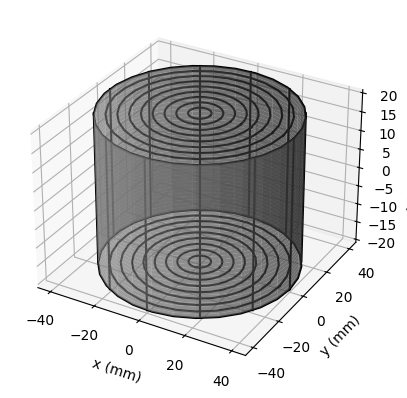

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters for the cylinder
num_layers = 40
length = 40
radius = 40

# Creating the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generating cylinder data
theta = np.linspace(0, 2 * np.pi, 30)
z = np.linspace(-length / 2, length / 2, num_layers)
theta_grid, z_grid = np.meshgrid(theta, z)
x_grid = radius * np.cos(theta_grid)
y_grid = radius * np.sin(theta_grid)

# Plotting the cylindrical surface
ax.plot_surface(x_grid, y_grid, z_grid, color='gray', alpha=0.7, edgecolor='none')

# Adding radial grid lines before rotation
num_radial_lines = 12
for i in range(num_radial_lines):
    angle = 2 * np.pi * i / num_radial_lines
    x_line = radius * np.cos(angle)
    y_line = radius * np.sin(angle)
    ax.plot([x_line, x_line], [y_line, y_line], [-length / 2, length / 2], color='k')

# Adding circular grid lines before rotation
num_circles = 10
radii = np.linspace(0, radius, num_circles)
for r in radii:
    x_circle = r * np.cos(theta)
    y_circle = r * np.sin(theta)
    ax.plot(x_circle, y_circle, np.zeros_like(theta) - length / 2, color='k')
    ax.plot(x_circle, y_circle, np.zeros_like(theta) + length / 2, color='k')

# Rotate the cylinder to lay on its side (along y-axis)
# ax.view_init(elev=90, azim=90)

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('Layer Number')

# Display the plot
plt.show()


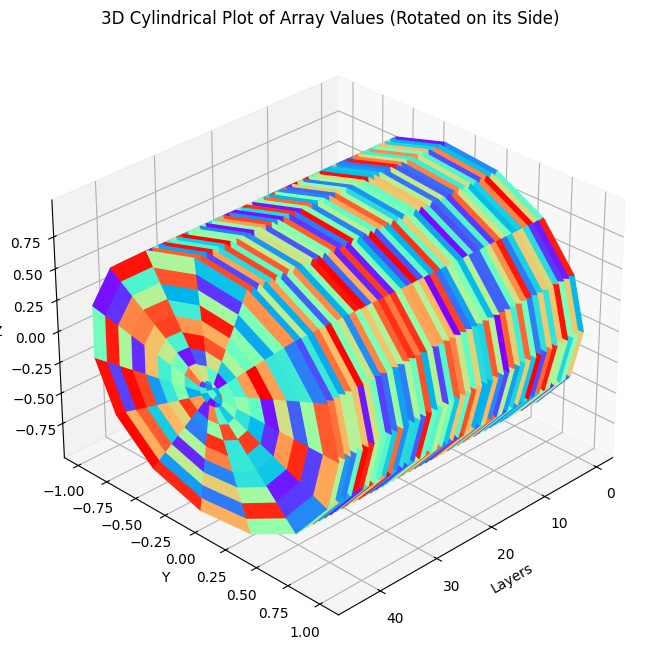

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate the array of 6480 values (example data)
data = np.random.rand(6480)

# Reshape the data to 45 layers x 16 slices x 9 circles
data_reshaped = data.reshape((45, 16, 9))

# Create the cylindrical coordinates
theta = np.linspace(0, 2 * np.pi, 16)
r = np.linspace(0.1, 1, 9)
theta, r = np.meshgrid(theta, r)

# Create the X, Y, Z coordinates for the cylinder rotated on its side
Y = r * np.cos(theta)
Z = r * np.sin(theta)

# Create a figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each layer separately
for i in range(45):
    X = np.full_like(Y, i)  # Each layer is at a constant X value
    values = data_reshaped[i, :, :].T  # Transpose to match the shape
    ax.plot_surface(X, Y, Z, facecolors=plt.cm.rainbow(values / np.max(values)), rstride=1, cstride=1, shade=False)

# Add labels
ax.set_xlabel('Layers')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the view angle
ax.view_init(elev=30, azim=45)  # Adjust these values to change the view

plt.title('EM Shower in Calorimeter')
plt.show()


In [2]:
test = [1 + 1 * x for x in range(6)]
print(test)

[1, 2, 3, 4, 5, 6]


In [9]:
test[0:3] = [sum(test[1:3])]
print(test[1:3])
print(test)

[]
[0]


In [3]:
test[0] += ''.join(test[1:3])

TypeError: sequence item 0: expected str instance, int found